# Imports

In [1]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import pygad

# Topics 

## 1. Brute Force Optimization with Latin Hypercube sampling

### 1.1 The idea
When you want to find the minimum of a dataset, the most reasonable thing to do, the thing that even a non technical person would suggest is this:

__Let's explore all the possibilities!__

Now this is possible only for very limited cases. For example, we can do it if we only have four different choices for one parameter. Or 2 choices for 3 parameters. Or 3 choices for 2 parameters. I think you get the gist.

If you have only a few choices it is worth to try and explore them all. But if your parameter space is continuous, you are already out of business (you can't explore all the possibilities of a closed infinite space). You can still use this kind of logic, though. A very simple thing to do is to sample your parameter space (X) by dividing it into multiple steps (grid approach). Nonetheless, the literature clearly shows that when you want to do a few simulations, it is smarter to add some randomness to this. **Latin Hypercube Sampling** is a very good alternative.

Now this is the equivalent of **enumerating the possibilities** but they are not quite ALL the possibilities, because we are in the continuous space. It's a very simple approach and it is prone to the presence of local minima. On the other hand, **when the number of simulations increases, the probability of being in a local minimum gets lower** (you probably explored all the minima and got to the lowest of them all).

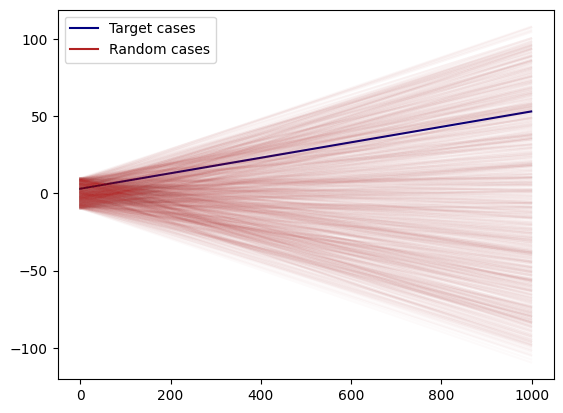

In [2]:
coefficients_start = [-10,-10]
coefficients_end = [10,10]
x = np.linspace(0,10,1000)

def f(c_start,c_end):
    return c_start*x+c_end

def compute_error(f_target,c_start,c_end):
    return np.sum(np.abs(f_target-f(c_start,c_end)))

c_start_target, c_end_target = 5,3
plt.plot(f(c_start_target,c_end_target),label='Target cases',color='navy')
for _ in range(1000):
    plt.plot(f(np.random.choice(np.linspace(-10,10,1000)),np.random.choice(np.linspace(-10,10,1000))),color='firebrick',alpha=0.02)
plt.plot(0,0,label='Random cases',color='firebrick',alpha=1)
plt.legend()

In [3]:
nums_list = [1,2,5,10,100,1000,10_000,100_000]
best_estimate_list = []
for num in nums_list:
    sampler = qmc.LatinHypercube(d=2)
    sample = sampler.random(n=num)
    sample_scaled = qmc.scale(sample, coefficients_start, coefficients_end)
    c_start_target, c_end_target = 5,3
    f_target = f(c_start_target,c_end_target)
    error_list = np.array([compute_error(f_target,s[0],s[1]) for s in sample_scaled])
    best_estimate = sample_scaled[np.argmin(error_list)]
    best_estimate_list.append(best_estimate)
    print(f'Our estimate with {num} samples is {best_estimate}')

Our estimate with 1 samples is [ 6.95159531 -1.42049731]
Our estimate with 2 samples is [4.28045783 6.82238429]
Our estimate with 5 samples is [ 6.73441167 -5.49692247]
Our estimate with 10 samples is [3.08118206 9.60466817]
Our estimate with 100 samples is [5.05143601 1.28101689]
Our estimate with 1000 samples is [5.04302185 2.47393608]
Our estimate with 10000 samples is [5.0591097  2.55885412]
Our estimate with 100000 samples is [5.00875081 2.94283824]


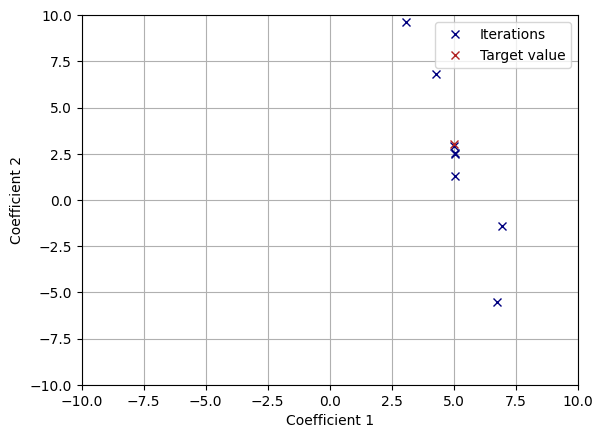

In [4]:
best_estimate_list = np.array(best_estimate_list)
plt.plot(best_estimate_list[:,0],best_estimate_list[:,1],'x',color='navy',label='Iterations')
plt.plot(c_start_target,c_end_target,'x',color='firebrick',label='Target value')
plt.grid()
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('Coefficient 1')
plt.ylabel('Coefficient 2')
plt.legend()

## 2. Gradient Descent 
### 2.1 The idea
The method that I'm going to show is very well-known in the Machine Learning community because it's the method that gets used to train Neural Networks.

This idea is the following:

1. We start with a random parameter vector x_start. Anywhere in the k-dimensional space of the problem of interest.
2. We compute the loss for that random parameter x_start.
3. We compute the gradient of the loss for that specific x_start and we move in the opposite direction

Minimum at x = 2.9999571825692226, f(x) = 1.8333323783762876e-09 after 50 iterations


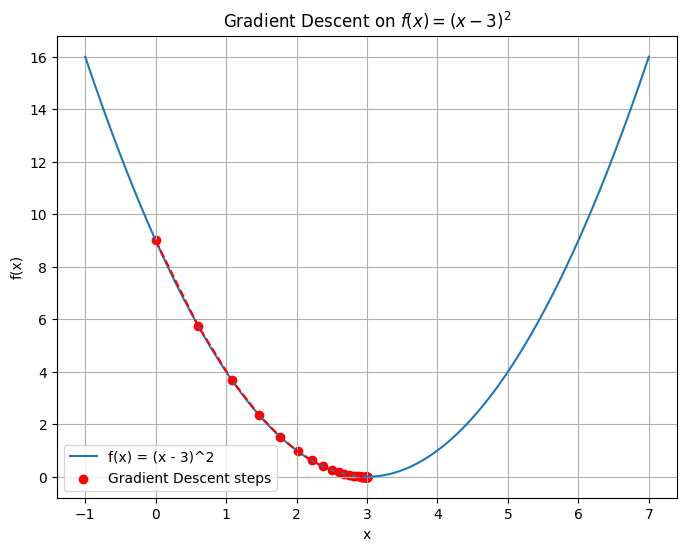

In [5]:
# Define the function (but no derivative this time)
def f(x):
    return (x - 3) ** 2

# Numerical derivative using central difference
def numerical_derivative(f, x, h=1e-5):
    return (f(x + h) - f(x - h)) / (2 * h)

# Gradient Descent parameters
x_start = 0.0        # Initial guess
learning_rate = 0.1  # Step size multiplier
max_iterations = 50  # Maximum number of iterations
tolerance = 1e-6     # Tolerance for stopping

# Lists to store the values of x and f(x) for plotting
x_values = []
f_values = []

# Gradient Descent loop
x = x_start
for i in range(max_iterations):
    gradient = numerical_derivative(f, x)
    x_new = x - learning_rate * gradient

    # Store values for plotting
    x_values.append(x)
    f_values.append(f(x))

    # Check for convergence
    if np.abs(x_new - x) < tolerance:
        break

    x = x_new

# Print the result
print(f"Minimum at x = {x}, f(x) = {f(x)} after {i+1} iterations")

# Plotting the function and the Gradient Descent steps
x_plot = np.linspace(-1, 7, 400)
y_plot = f(x_plot)

plt.figure(figsize=(8, 6))
plt.plot(x_plot, y_plot, label='f(x) = (x - 3)^2')
plt.scatter(x_values, f_values, color='red', label='Gradient Descent steps')
plt.plot(x_values, f_values, color='red', linestyle='--')
plt.title('Gradient Descent on $f(x) = (x - 3)^2$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()

Minimum found at x = -0.010719724776175, f(x) = 2.000003708695979 after 1000 iterations


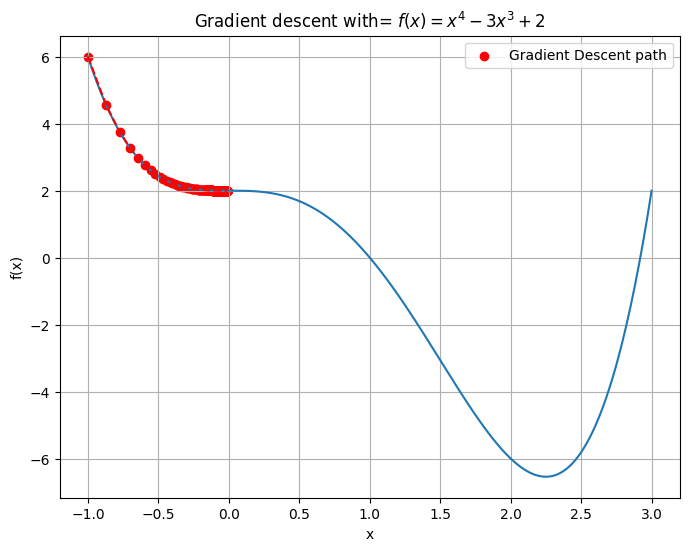

In [6]:
# Define the function
def f(x):
    return x**4 - 3*x**3 + 2

# Numerical derivative using central difference
def numerical_derivative(f, x, h=1e-5):
    return (f(x + h) - f(x - h)) / (2 * h)

# Gradient Descent parameters
x_start = -1.0       # Start close to the local minimum
learning_rate = 0.01
max_iterations = 1000
tolerance = 1e-12

# Lists to store the values of x and f(x) for plotting
x_values = []
f_values = []

# Gradient Descent loop
x = x_start
for i in range(max_iterations):
    gradient = numerical_derivative(f, x)
    x_new = x - learning_rate * gradient

    # Store values for plotting
    x_values.append(x)
    f_values.append(f(x))

    # Check for convergence
    if np.abs(x_new - x) < tolerance:
        break

    x = x_new

# Print the result
print(f"Minimum found at x = {x}, f(x) = {f(x)} after {i+1} iterations")

# Plotting the function and the Gradient Descent steps
x_plot = np.linspace(-1, 3, 400)
y_plot = f(x_plot)

plt.figure(figsize=(8, 6))
plt.plot(x_plot, y_plot)
plt.scatter(x_values, f_values, color='red', label='Gradient Descent path')
plt.plot(x_values, f_values, color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(r'Gradient descent with= $f(x) = x^4 - 3x^3 + 2$')
plt.legend()
plt.grid(True)
plt.show()

It found a local minimum , one can solve this by using momentun + SGD 

## 3. Bayesian Optimization

### 3.1 The idea
Bayesian Optimization is used when the black box function is actually computationally intensive, and you might have to wait a long time (tens of seconds) before getting your output f(x) given your input x.

The strategy is the following:

1. You take a small fraction of points and you compute your loss function on that small fraction of points.
2. The couples (x,f(x)) for those fraction of points are used to train a Gaussian Process Regression (GPR)
3. The trained GPR is used to intensively sample the parameter space.
4. The Expected Improvement (EI) tells you where the GPR is uncertain. In other words, using the EI we can select the areas where the global minimum or maximum might be
5. You select the point with the largest EI. Compute (x_new, f(x_new)) and retrain the GPR. Then rerun 3,4 and 5


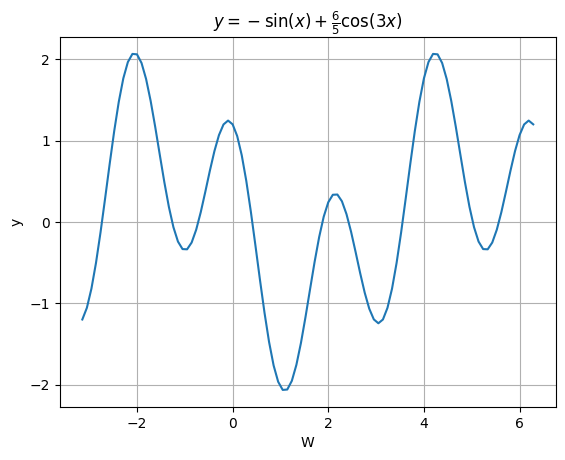

In [7]:
import numpy as np
import matplotlib.pyplot as plt
X = np.linspace(-1*np.pi,2*np.pi,100)
Y = -np.sin(X)+1.2*np.cos(3*X)
plt.plot(X, Y)
plt.xlabel('W')
plt.ylabel('y')
plt.title(r'$y=-\sin(x)+\frac{6}{5}\cos(3x)$',fontsize=12,weight='bold')
plt.grid()
plt.show()

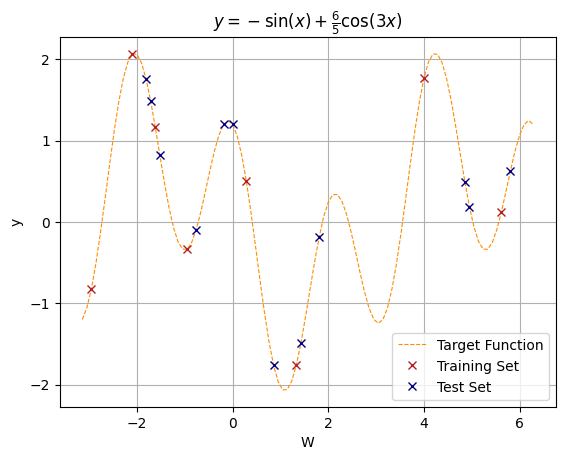

In [8]:
num_X = 20
ratio = 0.40
random_index = np.random.choice(np.arange(0,len(X)),replace=False,size=num_X)
train_set, test_set = random_index[0:int(num_X*ratio)],random_index[int(num_X*ratio):]
plt.plot(X, Y,label='Target Function',ls='--',color='darkorange',lw=0.8)
plt.plot(X[train_set],Y[train_set],'x',color='firebrick',label='Training Set')
plt.plot(X[test_set],Y[test_set],'x',color='navy',label='Test Set')
plt.xlabel('W')
plt.ylabel('y')
plt.title(r'$y=-\sin(x)+\frac{6}{5}\cos(3x)$',fontsize=12,weight='bold')
plt.legend()
plt.grid()
plt.show()

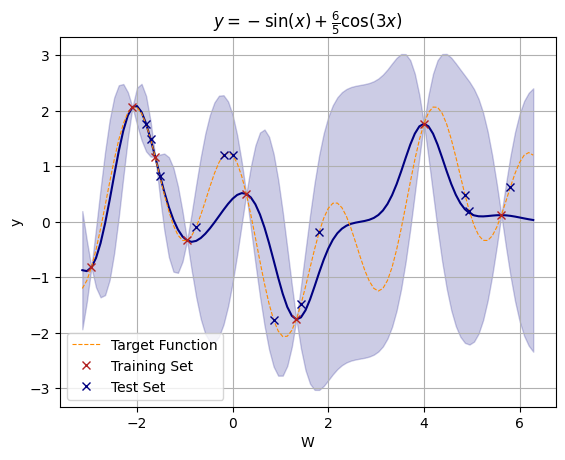

In [9]:
X_train, X_test, y_train, y_test = X[train_set], X[test_set], Y[train_set], Y[test_set]
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train.reshape(-1,1), y_train)
mean, std = gaussian_process.predict(X.reshape(-1,1),return_std=True)
plt.plot(X,mean,color='navy')
plt.fill_between(X,mean-2*std,mean+2*std,color='navy',alpha=0.2)
plt.plot(X, Y,label='Target Function',ls='--',color='darkorange',lw=0.8)
plt.plot(X[train_set],Y[train_set],'x',color='firebrick',label='Training Set')
plt.plot(X[test_set],Y[test_set],'x',color='navy',label='Test Set')
plt.xlabel('W')
plt.ylabel('y')
plt.title(r'$y=-\sin(x)+\frac{6}{5}\cos(3x)$',fontsize=12,weight='bold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def black_box_function(x):
    return -np.sin(x) + 1.2 * np.cos(3 * x)


num_iterations = 9
plt.figure(figsize=(10, 6))
start_X, start_Y = X_train, y_train
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
X_range = np.linspace(X.min(), X.max(), 1000)
plt.figure(figsize=(20,10))
for i in range(num_iterations):
    plt.subplot(3,3,i+1)
    # Fit the Gaussian process model to the sampled points
    gaussian_process.fit(start_X.reshape(-1, 1), start_Y)

    # Determine the point with the highest observed function value
    best_idx = np.argmin(start_Y)
    best_x = start_X[best_idx]
    best_y = start_Y[best_idx]


    # Generate the Upper Confidence Bound (UCB) using the Gaussian process model
    computed_ei = expected_improvement(X_range, gaussian_process, best_y)
    y_pred, y_pred_boundaries = gaussian_process.predict(X_range.reshape(-1,1), return_std=True)

    # Plot the UCB function
    plt.fill_between(X_range, y_pred-2*y_pred_boundaries, y_pred+2*y_pred_boundaries, color='navy', label='Uncertainty Boundaries',alpha=0.2)
    # Plot the black box function, surrogate function, previous points, and new points
    plt.plot(X_range, black_box_function(X_range), color='darkorange', label='Black Box Function')
    #plt.plot(x_range, ucb, color='red', linestyle='dashed', label='Surrogate Function')
    plt.scatter(start_X, start_Y, color='red', label='Previous Points')
    plt.plot(X_range, y_pred,color='navy',label='GPR Prediction ')

    new_x = X_range[np.argmax(computed_ei)]  # Select the next point based on UCB
    new_y = black_box_function(new_x)
    start_X = np.append(start_X, new_x)
    start_Y = np.append(start_Y, new_y)
    plt.scatter(new_x, new_y, color='green', label='New Points')

    #plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"Iteration #{i+1}")
    plt.legend(fontsize=4)

## 4. Genetic Algorithms

### 4.1 The idea
The Genetic Algorithm is another extremely fascinating method to find the global optimum of a black box function. The logic is to select a random set of candidates, choose the best ones based on your cost function, mate them together, and evolve them into new candidates. More precisely, these are the steps:

1. You start with a randomly generated population of possible solutions.
2. You evaluate each candidate's fitness using a predefined cost (or fitness) function. The fitness function tells you how "good" a solution is.
3. You combine pairs of selected candidates (parents) to produce new candidates (offspring). This process is done by exchanging parts of the parent solutions to create diversity in the offspring and it is usually referred as mating.
4. You can (and usually do) introduce random changes to some of the offspring's genes (individual parts of the solution) to maintain diversity within the population. This is just to introduce some randomness (and it's actually helpful to avoid local minima)
5. You replace the old population with the new set of candidates and repeat the process over multiple generations.

In [14]:
def func_to_minimize(x, y):
    return x * np.sin(4 * x) +1.1 * y * np.sin(2 * y)

# Define the fitness function for the GA
def fitness_func(ga_instance, solution, solution_idx):
    x, y = solution
    output = func_to_minimize(x, y)
    fitness = -output   # Adding a small constant to avoid division by zero
    return fitness

# Set up the GA parameters
num_generations = 400
num_parents_mating = 4
sol_per_pop = 8
num_genes = 2  # We have two variables: x and y

# The range for the initial population
init_range_low = 0
init_range_high = 10

parent_selection_type = "sss"
keep_parents = 1
crossover_type = "single_point"
mutation_type = "random"
mutation_percent_genes = 10

# Initialize the GA
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                      save_solutions=True)

# Run the GA
ga_instance.run()

# Get the best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

# Calculate the output using the best solution
predicted_output = func_to_minimize(solution[0], solution[1])
print("Predicted output based on the best solution : {prediction}".format(prediction=predicted_output))

C:\Users\Oreo\AppData\Roaming\Python\Python312\site-packages\pygad\pygad.py:748: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
C:\Users\Oreo\AppData\Roaming\Python\Python312\site-packages\pygad\pygad.py:1162: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when ei

Parameters of the best solution : [7.46933851 5.54144561]
Fitness value of the best solution = 13.537828646943675
Predicted output based on the best solution : -13.537828646943675


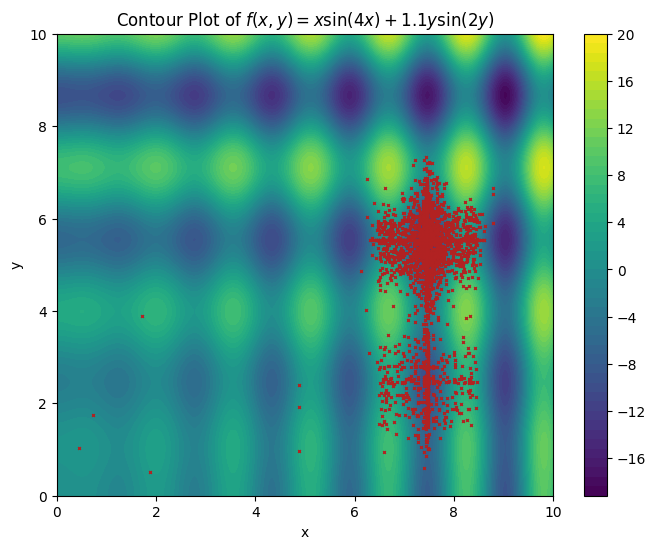

In [16]:
x_values = np.linspace(0, 10, 400)
y_values = np.linspace(0, 10, 400)
# Create a meshgrid
X, Y = np.meshgrid(x_values, y_values)
# Compute the function values on the grid
Z = func_to_minimize(X, Y)
# Plot the contour
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title('Contour Plot of $f(x, y) = x \\sin(4x) + 1.1y \\sin(2y)$')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(np.array(ga_instance.solutions)[:,0],np.array(ga_instance.solutions)[:,1],'x',markersize=2,color='firebrick')
plt.xlim(0,10)
plt.ylim(0,10)
plt.show()